# Image classification with transfer learning VGG16


# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Importing dataset from CIFAR
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# Importing hode encodinng
from tensorflow.keras.utils import to_categorical

# #Importing Transfer Learning model VGG16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
import tensorflow as tf

# to refresh the model after each iteration model
from keras.backend import clear_session

# import confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the Dataset


In [45]:
# Load CIFAR-10 dataset and print shapes
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# **Pre-processing classes **

In [46]:
# Convert classes into categories with one hot encoding and check shape.
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("y_train_cat shape:", y_train.shape)
print("y_test_cat shape:", y_test.shape)

y_train_cat shape: (50000, 10)
y_test_cat shape: (10000, 10)


# Create the base model from the pre-trained convnets

In [48]:
IMG_SIZE = (224, 224)

base_model = VGG16(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False


### Building, preprocessing and training Transfer Learning Model VG16

In [28]:
# clear session
clear_session()

In [49]:
# architecture model

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,757,898 (56.30 MB)

 Trainable params: 42,826 (167.29 KB)

 Non-trainable params: 14,715,072 (56.13 MB)

In [50]:
#Pre processing imput data for the VGG16 model

from tensorflow.keras.applications.vgg16 import preprocess_input

def prepare_dataset(images, labels, batch_size, img_size=(224, 224)):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.image.resize(x, img_size), y))
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [51]:
# Compile and fit

BATCH_SIZE = 128
train_dataset = prepare_dataset(x_train, y_train, BATCH_SIZE, IMG_SIZE)
test_dataset = prepare_dataset(x_test, y_test, BATCH_SIZE, IMG_SIZE)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Fit (train) the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15
)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.5939 - loss: 1.2321 - val_accuracy: 0.8316 - val_loss: 0.4991
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.8086 - loss: 0.5630 - val_accuracy: 0.8431 - val_loss: 0.4571
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8351 - loss: 0.4843 - val_accuracy: 0.8468 - val_loss: 0.4493
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8446 - loss: 0.4515 - val_accuracy: 0.8523 - val_loss: 0.4254
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.8496 - loss: 0.4316 - val_accuracy: 0.8508 - val_loss: 0.4358
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.8578 - loss: 0.4142 - val_accuracy: 0.8551 - val_loss: 0.4245
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.8621 - loss: 0.4020 - val_accuracy: 0.8583 - val_loss: 0.4114
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8649 - loss: 0.3915 - 

# Evaluation

In [55]:
# Evaluate

train_loss, train_acc = model.evaluate(train_dataset, verbose=0)

test_loss, test_acc = model.evaluate(test_dataset, verbose=0)

print("FINAL RESULTS")
print(f"Training Accuracy:   {train_acc:.4f}")

print(f"Test Accuracy:       {test_acc:.4f}")

FINAL RESULTS
Training Accuracy:   0.9074
Test Accuracy:       0.8615


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step


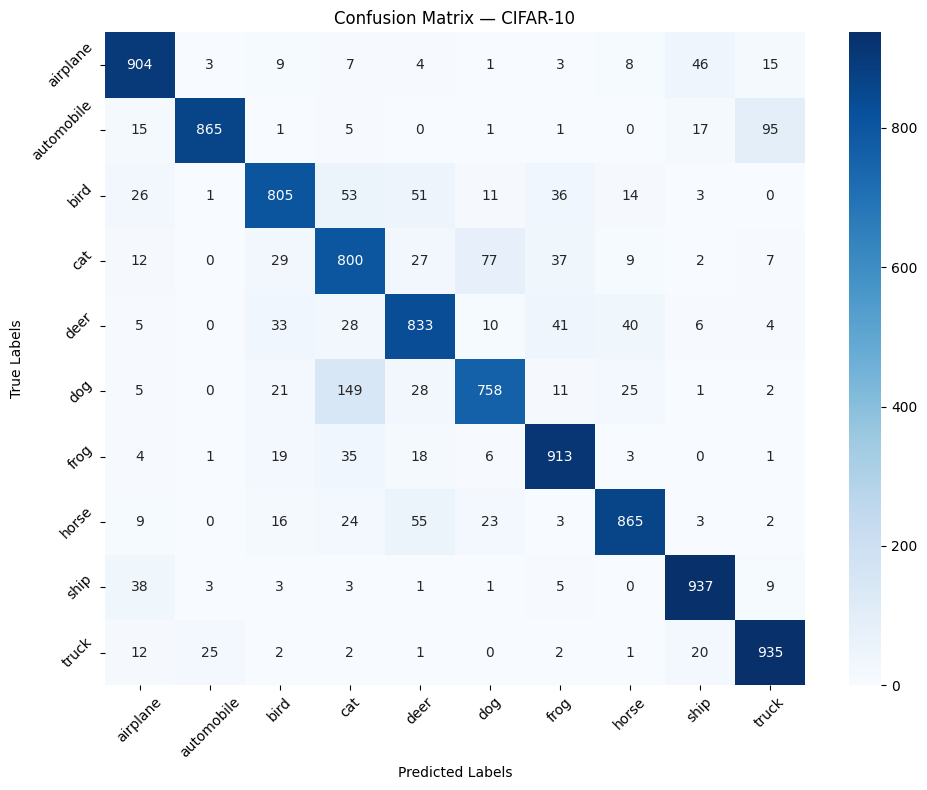


📊 Classification Report:

              precision    recall  f1-score   support

    airplane       0.88      0.90      0.89      1000
  automobile       0.96      0.86      0.91      1000
        bird       0.86      0.81      0.83      1000
         cat       0.72      0.80      0.76      1000
        deer       0.82      0.83      0.83      1000
         dog       0.85      0.76      0.80      1000
        frog       0.87      0.91      0.89      1000
       horse       0.90      0.86      0.88      1000
        ship       0.91      0.94      0.92      1000
       truck       0.87      0.94      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [57]:

# CIFAR-10 class labels
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Predictions on Test Set
# ============================
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix
# ============================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix — CIFAR-10')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
# ============================
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
